In [ ]:
import pandas as pd
import numpy as np
import datetime
import os
from keras.models import Sequential, load_model
from keras.layers import Dense, Bidirectional, LSTM, SimpleRNN, Dropout
from keras.utils.vis_utils import plot_model
from keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard
from keras import optimizers
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import pickle

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
INPUT_DIRECTORY='/content/drive/MyDrive/COVID-Neural-Net/datasets/input/'
OUTPUT_DIRECTORY='/content/drive/MyDrive/COVID-Neural-Net/datasets/output/'
MODEL_DIRECTORY='/content/drive/MyDrive/COVID-Neural-Net/models/'
MODEL_LOGS='/content/drive/MyDrive/COVID-Neural-Net/models/logs'


df_train = pd.read_csv(INPUT_DIRECTORY+'resampledinput.csv')
df_train = pd.DataFrame(df_train)
df_test = pd.read_csv(INPUT_DIRECTORY+'inputdataset.csv')
df_test = pd.DataFrame(df_test)
df_train.shape

(92682, 48)

In [ ]:
################# Splitting into Train -Test Data #######
X_train,X,y_train,y = train_test_split(df_train.drop(['covid19_test_results_Positive'], axis=1),df_train['covid19_test_results_Positive'],test_size=0.2,stratify=df_train['covid19_test_results_Positive'],random_state=42)
x,X_test,y,y_test = train_test_split(df_test.drop(['covid19_test_results_Positive'], axis=1),df_test['covid19_test_results_Positive'],test_size=0.2,stratify=df_test['covid19_test_results_Positive'],random_state=42)

In [ ]:
# X = df.drop('covid19_test_results_Positive', axis=1)
# y = df['covid19_test_results_Positive']

In [ ]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(47, input_dim=47, activation='relu'))
    model.add(Dense(47, activation='relu'))
    model.add(Dense(47, activation='relu'))
    model.add(Dense(25, activation='relu'))
    # model.add(Dense(25, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(loss ='binary_crossentropy', optimizer=optimizers.Adam(lr=0.001), metrics =['accuracy'])
    
    return model

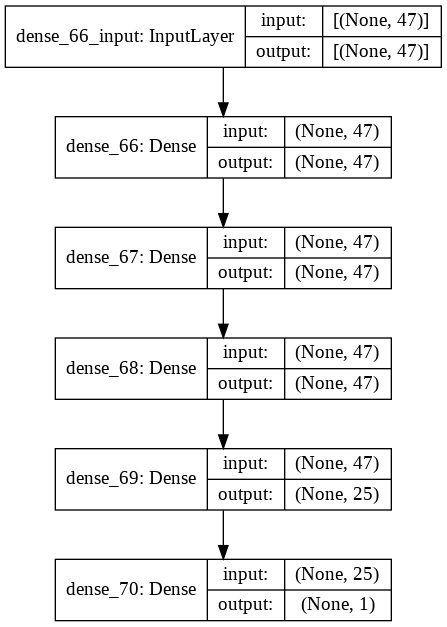

In [ ]:
# model = KerasClassifier(build_fn=create_larger, epochs=100, batch_size=5, verbose=0)
model = create_model()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# history = model.fit(X_train, y_train, validation_data = (X_test,y_test), epochs=100, batch_size=64)

In [ ]:
def create_RNN(input_shape):
    # create model
    model = Sequential()
   # Recurrent layer
    model.add(LSTM(47, return_sequences=False, dropout=0.1, recurrent_dropout=0.1))

    # Fully connected layer
    model.add(Dense(47, activation='relu'))

    # Dropout for regularization
    model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='softmax'))

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [ ]:
model = create_RNN(input_shape=(None,47))
# plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
print(model.summary())

ValueError: ignored

In [ ]:
rnn_model = create_RNN(input_shape=(None,47))
history = run_model(rnn_model, X_train, y_train, X_test, y_test, batch_size=256, no_epochs=200, model_name="Recurrent_NN")

2021_05_07_05_13_47
Epoch 1/200


ValueError: ignored

In [ ]:
def run_model(model, train_x, train_y, test_X, test_y, batch_size, no_epochs, model_name):
    
    datetime_now = datetime.datetime.now()
    datetime_now = datetime_now.strftime("%Y_%m_%d_%H_%M_%S")
    print(datetime_now)
    os.mkdir(MODEL_DIRECTORY+str(datetime_now))
    
    filepath = MODEL_DIRECTORY+str(datetime_now) + '/model-{epoch:02d}-{val_accuracy:.2f}.hdf5'
    checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1,
                                 save_best_only=False, mode='auto', period=1)
    
    checkpoint_best = ModelCheckpoint(MODEL_DIRECTORY+model_name+".hdf5", monitor='loss', verbose=1,
                                       save_best_only=True, mode='auto', period=1)
    
    csv_logger = CSVLogger(MODEL_LOGS+'model_history_log.log', separator=',', append=True)

    tensorboard_callback = TensorBoard()

    history = model.fit(train_x,
                        train_y,
                        batch_size=batch_size,
                        epochs=no_epochs,
                        verbose=1,
                        validation_data=(test_X, test_y),
                        callbacks=[checkpoint, checkpoint_best, csv_logger, tensorboard_callback])

    pd.DataFrame(history.history).to_csv(MODEL_LOGS+"history.csv")
    model.save_weights(MODEL_DIRECTORY+'model_weights.h5')
    
    return history
    
history = run_model(model, X_train, y_train, X_test, y_test, batch_size=256, no_epochs=200, model_name='Dense_Sequential_Model')


2021_05_07_05_21_27
Epoch 1/200
290/290 [==============================] - 2s 4ms/step - loss: 0.5786 - accuracy: 0.6940 - val_loss: 0.4243 - val_accuracy: 0.8625

Epoch 00001: saving model to /content/drive/MyDrive/COVID-Neural-Net/models/2021_05_07_05_21_27/model-01-0.86.hdf5

Epoch 00001: loss improved from inf to 0.54571, saving model to /content/drive/MyDrive/COVID-Neural-Net/models/Dense_Sequential_Model.hdf5
Epoch 2/200
290/290 [==============================] - 1s 3ms/step - loss: 0.5146 - accuracy: 0.7390 - val_loss: 0.4688 - val_accuracy: 0.8125

Epoch 00002: saving model to /content/drive/MyDrive/COVID-Neural-Net/models/2021_05_07_05_21_27/model-02-0.81.hdf5

Epoch 00002: loss improved from 0.54571 to 0.50689, saving model to /content/drive/MyDrive/COVID-Neural-Net/models/Dense_Sequential_Model.hdf5
Epoch 3/200
290/290 [==============================] - 1s 3ms/step - loss: 0.4937 - accuracy: 0.7550 - val_loss: 0.3988 - val_accuracy: 0.8588

Epoch 00003: saving model to /cont

KeyboardInterrupt: ignored

In [ ]:
def load_trained_model(filepath):
    new_model = load_model(filepath)
    return new_model

MODEL_NAME='Dense_Sequential_Model'
model = load_trained_model(MODEL_DIRECTORY+MODEL_NAME+".hdf5")
print(model.summary())

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_62 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_63 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_64 (Dense)             (None, 47)                2256      
_________________________________________________________________
dense_65 (Dense)             (None, 1)                 48        
Total params: 9,072
Trainable params: 9,072
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
y_pred = model.predict(X_test)

In [ ]:
X_test.head()

,age,temperature,pulse,diabetes_0,diabetes_1,loss_of_smell_0,loss_of_smell_1,cancer_0,cancer_1,high_risk_exposure_occupation_0,high_risk_exposure_occupation_1,muscle_sore_0,muscle_sore_1,diarrhea_0,diarrhea_1,cough_0,cough_1,smoker_0,smoker_1,headache_0,headache_1,fever_0,fever_1,fatigue_0,fatigue_1,sob_0,sob_1,sore_throat_0,sore_throat_1,loss_of_taste_0,loss_of_taste_1,autoimmune_dis_0,autoimmune_dis_1,high_risk_interactions_0,high_risk_interactions_1,chd_0,chd_1,runny_nose_0,runny_nose_1,htn_0,htn_1,copd_0,copd_1,labored_respiration_0,labored_respiration_1,asthma_0,asthma_1
29818,0.45,0.540125,0.335469,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0
22567,0.63,0.516393,0.416000,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0
4974,0.49,0.516393,0.392000,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,1,0
41733,0.65,0.540125,0.335469,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,1,0,0,0,1,0,1,0,1,0,1,0,0,0,1,0
27556,0.61,0.475410,0.344000,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,0,1,1,0,1,0,1,0


In [ ]:
print(y_pred)

[[0.05654511]
 [0.63365406]
 [0.33637404]
 ...
 [0.08762118]
 [0.08904839]
 [0.40897918]]
